/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Loaded initial model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
________________________________________________________________________________________

Epoch 1/1


/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 219s 219ms/step - loss: 0.7019 - val_loss: 0.7066
/home/sohaib/Downloads/Features/testND/02463d899r.png
400
Processors Available = 8
[[1.         0.50799051 0.5184296  ... 0.08790241 0.25582108 0.14672315]
 [0.50799051 1.         0.58819824 ... 0.09296005 0.26611865 0.19156263]
 [0.5184296  0.58819824 1.         ... 0.06327584 0.23173243 0.13031395]
 ...
 [0.08790241 0.09296005 0.06327584 ... 1.         0.29797614 0.42312819]
 [0.25582108 0.26611865 0.23173243 ... 0.29797614 1.         0.24671139]
 [0.14672315 0.19156263 0.13031395 ... 0.42312819 0.24671139 1.        ]]


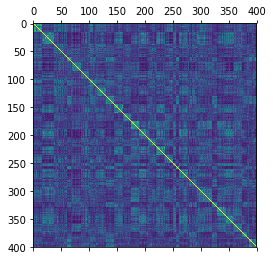

LST DIV = 50
ACT LIST  = 400
0 50
LST DIV = 50
ACT LIST  = 400
50 100
LST DIV = 50
ACT LIST  = 400
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04202d1131r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04267d231r', 'png']
100 150
LST DIV = 50
ACT LIST  = 400
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04217d469r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04202d1127r', 'png']
150 200
LST DIV = 50
ACT LIST  = 400
200 250
LST DIV = 50
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04202d1134r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04239d1007r', 'png']
ACT LIST  = 400
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04233d1035r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04932d71r', 'png']
LST DIV = 50
LST DIV = 50
ACT LIST  = 400
300 350
250 300
ACT LIST  = 400
350 400
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND'

['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04214d184r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04265d368r', 'png']
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04734d309r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04738d202r', 'png']
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04284d235r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04221d1136r', 'png']
TRUE POSITIVE 44
TRUE POSITIVE 45
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04214d187r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04933d102r', 'png']
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04734d310r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04202d1124r', 'png']
TRUE POSITIVE 45
['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04932d106r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testN

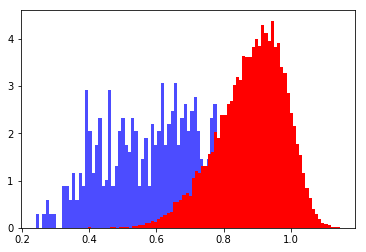

['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04736d090r', 'png']Match['', 'home', 'sohaib', 'Downloads', 'Features', 'testND', '04737d122r', 'png']
TRUE POSITIVE 31


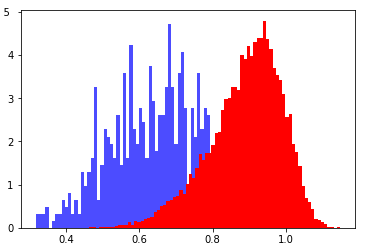

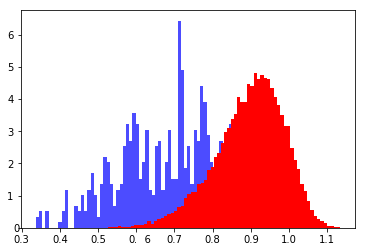

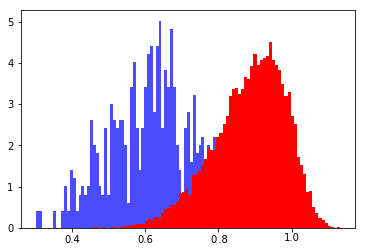

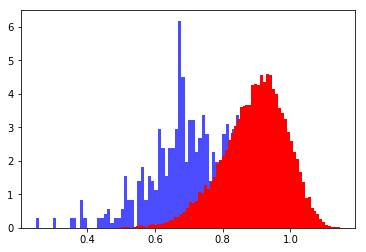

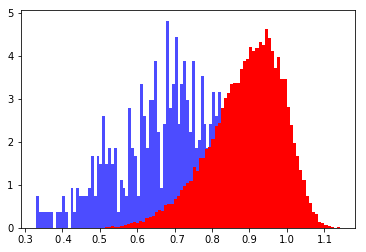

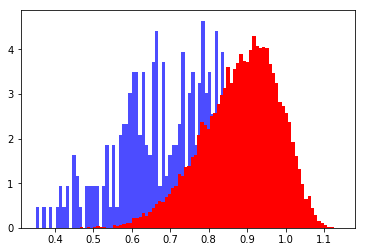

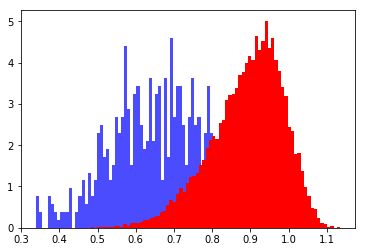

8
6
702
19248
Total TP = 340
5306
154294


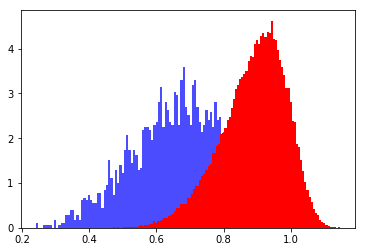

Standard deviation same = 0.13685414505812699
Standard deviation different = 0.09625567838804759
Blah = 5306
Min Same class = 0.2412480630524234
Min Different class = 0.3956760881322898
Minimum = [0.39567609 0.39567609 0.43784592 0.43784592 0.44609749 0.44609749
 0.44722578 0.44722578 0.45585046 0.45585046 0.4565768  0.4565768
 0.46430026 0.46430026 0.46532102 0.46532102 0.4654166  0.4654166
 0.46999766 0.46999766 0.47136783 0.47136783 0.47261956 0.47261956
 0.47273025 0.47273025 0.47450975 0.47450975 0.47532937 0.47532937
 0.47792246 0.47792246 0.47930645 0.47930645 0.48359634 0.48359634
 0.48715417 0.48715417 0.48741359 0.48741359 0.48781002 0.48781002
 0.48894109 0.48894109 0.48926714 0.48926714 0.49207737 0.49207737
 0.49341825 0.49341825 0.49683747 0.49683747 0.49768985 0.49768985
 0.49930635 0.49930635 0.50286601 0.50286601 0.50464664 0.50464664]
Max = [1.11591979 1.11591979 1.11601143 1.11601143 1.1165793  1.1165793
 1.11722744 1.11722744 1.11838832 1.11838832 1.11943267 1.11943

In [5]:
import glob
import os
import re
import random
import math
import numpy as np
from PIL import ImageEnhance,ImageOps
import matplotlib.pyplot as plt
import cv2
from multiprocessing import Pool



from keras.optimizers import SGD,Adam
from keras.layers.core import Lambda
import keras.backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint,Callback
from keras.activations import relu
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import Input, GlobalAveragePooling2D ,Dense, Concatenate,Conv2DTranspose,Conv2D,Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50



# Putting this in for some errors that occur on my setup
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

K.set_image_dim_ordering('tf')

# np.random.seed(1337) # for reproducibility

#Number of classes
classes = 293

#Length of feature vector
FEATURES = 1024

#Image dimensions, square images only, can change to non-square
imgDimension = 256


#Sorting for file reads
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background, taken from stackoverflow
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result



'''
    Augment function, needs an image and a augment type integer.
'''
def augment(im,augType):
        if(augType == 0):
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            im = cv2.filter2D(im, -1, kernel)
        if(augType == 1):
            im = rotate_image(im,30)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 2):
            im = rotate_image(im,120)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 3):
            im = rotate_image(im,320)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 4):
            im = rotate_image(im,230)
            im =cv2.resize(im,(imgDimension,imgDimension))
        if(augType == 5):
            im = np.flip(im,0)
        if(augType == 6):
            im = np.flip(im,1)
        if(augType == 7):
            im[0:70] = 0
        if(augType == 8):
            cl1 = clahe.apply(im[:,:,0])
            cl1[cl1<10] = 0
            im[:,:,0] = cl1
            im[:,:,1] = cl1
            im[:,:,2] = cl1
        if (augType == 9):
            im = cv2.blur(im, (3,3))
        return im


"""
    Keras generator for loading images in a batch hard fashion. Multithreaded by default in keras.
    Modeled for a Tensorflow backend. Takes a static string to the dataset location.
"""

def customGenerator():
    BATCH_SIZE = 12 #Total images in batch, can fit 12 in a GTX 1070 with ResNet 50.
    K = 4 #Num of images per class
    CLASSES = classes
    #Static paths for now
#     folderList = sorted(glob.glob('static_path_to_iris_directory'),key=numericalSort)
    folderList = sorted(glob.glob('insert_dataset_folder_here'),key=numericalSort)

    yConcat = np.zeros(shape = (BATCH_SIZE,1+FEATURES),dtype = np.int32)
    
    while True:
        y2 = np.zeros(shape = (1+FEATURES),dtype = np.int32)
        xI = np.zeros(shape = (BATCH_SIZE,3,imgDimension,imgDimension))
        numFm = random.sample(range(CLASSES), BATCH_SIZE//K)
        for x in range(BATCH_SIZE//K):
            imList = glob.glob(folderList[numFm[x]] + "/*")
            numIm = random.sample(range(len(imList)), K)
            #Augmentation, comment out if not needed
#             augType = random.sample(range(9), 1)
            for i in range(len(numIm)):
                im = cv2.imread(imList[numIm[i]])
                im = cv2.resize(im,(imgDimension,imgDimension))
#                 im= augment(im,augType)
                im= np.einsum('lij->jli', im)
                xI[i + (x*K)] = im
                
                yConcat [i + (x*K)] = y2
                yConcat [i + (x*K)][-1] = numFm[x]

        xI = np.einsum('abcd->acdb',xI)
        yield (xI,yConcat)

"""
    Batch hard loss implementation from https://omoindrot.github.io/triplet-loss
    Modified to use a soft margin.
"""
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask
def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(true, pred, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    
    embeddings = pred[:,classes:]
    labels = true[:,-1]
    margin = 0.8
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
#     hP = K.max(hardest_positive_dist)
#     hN =  K.min(hardest_negative_dist)
    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    #Usual batch hard triplet loss:
#     triplet_loss = tf.maximum(hP - hN + margin, 0.0)

    #Soft-margin triplet loss
    triplet_loss = K.log(1.0 + K.exp(hardest_positive_dist - hardest_negative_dist))
    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss
def batch_all_triplet_loss(true, pred, squared=False):
    """Build the triplet loss over a batch of embeddings.

    We generate all the valid triplets and average the loss over the positive ones.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
#     print (labels)
    embeddings = pred[:,classes:]
    labels = true[:,-1]
    print (labels)
    
#     print (embeddings)
    margin = 0.5
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
#     distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
    distances =  (dot_product/tf.expand_dims(square_norm, 0)*tf.expand_dims(square_norm, 1))
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = 1-distances
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-8

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def l2Norm(x):
    return  K.l2_normalize(x, axis=1)



"""Model generation"""
inp = Input(shape = (3,imgDimension,imgDimension))
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(imgDimension,imgDimension,3))


print ("Loaded initial model")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
fc2 = Dense(FEATURES,activation = 'relu',name = 'embedding_weights')(x)
fc2 = BatchNormalization()(fc2)
fc2 = Lambda(lambda x: K.l2_normalize(x, axis=1))(fc2)
predictions = Dense(293,name = 'predictions',use_bias = False)(fc2)
conc = concatenate([predictions, fc2], name='xF')
triplet_model = Model(inputs=base_model.input, outputs=conc)

"""Model generation"""

cwd = os.getcwd()
filepath=cwd + "/batchHard_ResNet50-{epoch:02d}-{loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

checkpoint = ModelCheckpoint(filepath, monitor='val_predictions_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
print (triplet_model.summary())

# triplet_model.load_weights("/home/sohaib/Downloads/Features/batchHard_ResNet50-08-0.58.hdf5",by_name = True)
"""
    Training happens here, same training and validation generators due to laziness
"""
gen_tr = customGenerator()
gen_te = customGenerator()
triplet_model.compile(loss=batch_hard_triplet_loss, optimizer=SGD(0.0004))
history = triplet_model.fit_generator(gen_tr, 
                          validation_data=gen_te,  
                          epochs=1, 
                          verbose=1,
                          workers=4,
                          steps_per_epoch=1000, 
                          validation_steps=50,callbacks = callbacks_list,use_multiprocessing = True)

